# Подготовка, предобработка и анализ данных

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import pandas as pd
import numpy as np
import torch
from functools import partial
import pytorch_lightning as pl
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import DataLoader

from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing.iterable_seq_len_limit import ISeqLenLimit
from ptls.data_load.iterable_processing.to_torch_tensor import ToTorch
from ptls.data_load.iterable_processing.feature_filter import FeatureFilter
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesIterableDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule
from ptls.preprocessing import PandasDataPreprocessor
from ptls.data_load.utils import collate_feature_dict
from ptls.data_load.iterable_processing_dataset import IterableProcessingDataset

from tqdm.auto import tqdm
#import lightgbm as ltb
from sklearn import preprocessing 
import gc
import pickle
import matplotlib.pyplot as plt

In [2]:
def reduce_mem_usage(df, cat_cols=[]):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    for col in df.columns:
        if col in cat_cols:
            df[col] = df[col].astype("category")
    start_mem = df.memory_usage().sum() / 1024**2
    # print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if col_type.startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif col_type.startswith('float'):
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    return df

## Таблицы таргетов

In [4]:
df_targ_1 = pd.read_parquet('C:\\data_sber_com\\data\\Hackathon\\train_target.parquet')
df_targ_2 = pd.read_parquet('C:\\data_sber_com\\data\\Hackathon\\test_target.parquet')
df_targ_1.head(2)
#Скачал все таргеты чтобы создать словарь айдишников для кодировки строки цифрами

,mon,target_1,target_2,target_3,target_4,client_id
0,2022-06-30,0,0,0,0,1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...
1,2022-07-31,0,0,0,0,1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...


In [5]:
cl_id_d = pd.concat([df_targ_1,df_targ_2])
label_encoder = preprocessing.LabelEncoder()
cl_id_d['client_id_num']= label_encoder.fit_transform(cl_id_d['client_id']) 

In [6]:
set_id_clients = set(cl_id_d['client_id'])
integerMapping=dict(zip(cl_id_d['client_id'],cl_id_d['client_id_num']))
with open("integerMapping", "wb") as dict_id:
    pickle.dump(integerMapping, dict_id)
# создал словарь соответствия и сохранил его

In [7]:
cl_id_d.head()

,mon,target_1,target_2,target_3,target_4,client_id,client_id_num
0,2022-06-30,0,0,0,0,1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...,113826
1,2022-07-31,0,0,0,0,1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...,113826
2,2022-08-31,0,0,0,0,1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...,113826
3,2022-09-30,0,0,0,0,1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...,113826
4,2022-10-31,0,0,0,0,1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...,113826


In [8]:
cl_id_d.groupby('mon')['target_3'].mean().sort_index()

mon
2022-02-28    0.005735
2022-03-31    0.012230
2022-04-30    0.013942
2022-05-31    0.008858
2022-06-30    0.006500
2022-07-31    0.006295
2022-08-31    0.008263
2022-09-30    0.008013
2022-10-31    0.005659
2022-11-30    0.005261
2022-12-31    0.004623
2023-01-31    0.003664
Name: target_3, dtype: float64

Text(0.5, 1.0, 'Сравнение таргетов по месяцам')

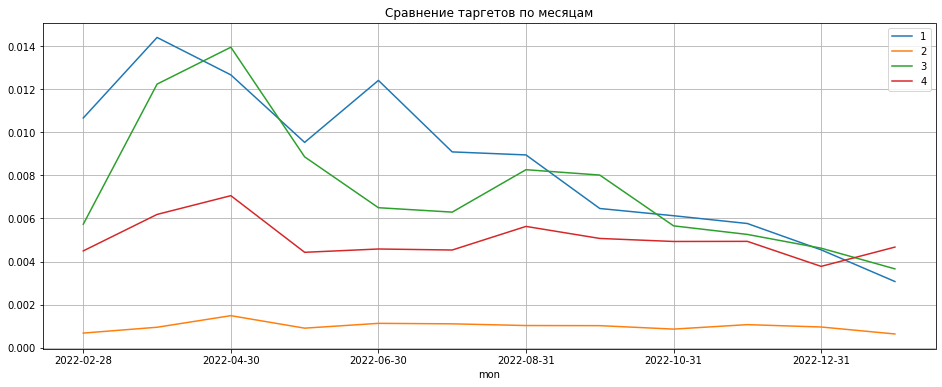

In [9]:
cl_id_d.groupby('mon')['target_1'].mean().sort_index().plot(figsize = (16,6), label= '1')
cl_id_d.groupby('mon')['target_2'].mean().sort_index().plot(figsize = (16,6), label= '2')
cl_id_d.groupby('mon')['target_3'].mean().sort_index().plot(figsize = (16,6), label= '3')
cl_id_d.groupby('mon')['target_4'].mean().sort_index().plot(figsize = (16,6), label= '4')
plt.grid()
plt.legend()
plt.title('Сравнение таргетов по месяцам')

Text(0.5, 1.0, 'Сравнение таргетов трейна и теста по отдельности по месяцам')

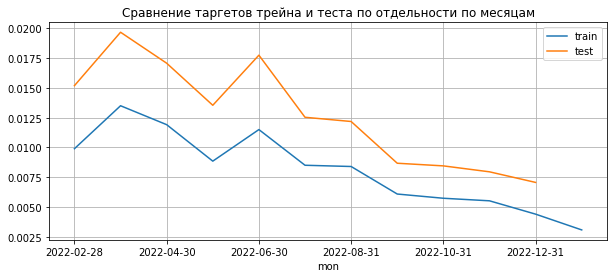

In [10]:
df_targ_1.groupby('mon')['target_1'].mean().sort_index().plot(figsize = (10,4), label= 'train')
df_targ_2.groupby('mon')['target_1'].mean().sort_index().plot(figsize = (10,4), label= 'test')
#cl_id_d.groupby('mon')['target_3'].mean().sort_index().plot(figsize = (16,6), label= '3')
#cl_id_d.groupby('mon')['target_4'].mean().sort_index().plot(figsize = (16,6), label= '4')
plt.grid()
plt.legend()
plt.title('Сравнение таргетов трейна и теста по отдельности по месяцам')

Text(0.5, 1.0, 'Сравнение таргетов трейна и теста по отдельности по месяцам')

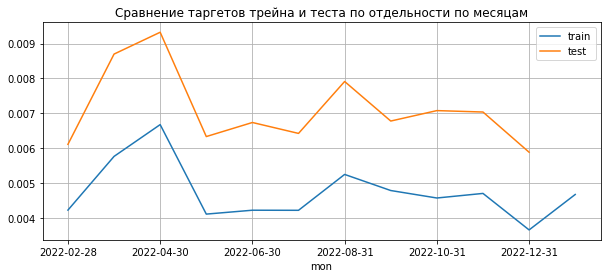

In [11]:
df_targ_1.groupby('mon')['target_4'].mean().sort_index().plot(figsize = (10,4), label= 'train')
df_targ_2.groupby('mon')['target_4'].mean().sort_index().plot(figsize = (10,4), label= 'test')
#cl_id_d.groupby('mon')['target_3'].mean().sort_index().plot(figsize = (16,6), label= '3')
#cl_id_d.groupby('mon')['target_4'].mean().sort_index().plot(figsize = (16,6), label= '4')
plt.grid()
plt.legend()
plt.title('Сравнение таргетов трейна и теста по отдельности по месяцам')

In [12]:
df_targ_1.groupby('client_id')['target_2'].sum().sort_values()

client_id
000006265d27d1166ed67506682be7380007a5bead4362f0a9795f7d97fb08e3    0
aa61e80574a3613cda0f5968a40917bd7c53c4e1a8054834ce98724739d36a8d    0
aa61fc54a2e35460c6163c32169dde64f2298f78563e451d2a0437c61c2c1683    0
aa62158ca710f2859e83e92e45313e03cf4f14e228d769ffea515eadca581825    0
aa6228801b68fb14a672c1efab064f6cbd228542109b9ee7e1c584695e8f4e1c    0
                                                                   ..
c78f037696c09811f403749e000ca7aeed00cbd07230abaacbfe77a2463870a7    6
f7058053ef3d675b22cc1e78568728a03e77f4ae8dc66ce8bc872b61cc4dfc4c    6
1913d8497daa22da70cfbd51bdedf21e1522b671543650818bb9509aa4246f07    6
1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b61d0d09d1e30aac7a8    6
5dc024441fb375934eb0069ec94dcc3266b34552f99ba33b46bc6c663932e261    9
Name: target_2, Length: 853892, dtype: int32

In [13]:
(df_targ_1.groupby('client_id')['target_2'].sum()>2).sum()

263

In [14]:
df_targ_1.groupby('client_id')['target_2'].count().count(), df_targ_1.groupby('client_id')['target_2'].sum().sum()

(853892, 9624)

In [15]:
df_targ_1[df_targ_1['client_id'] == '402194ef2f46650d59063a4c57a0e845d624383c8f920a5f80b01f726b55922f']

,mon,target_1,target_2,target_3,target_4,client_id
1615320,2022-02-28,1,0,0,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615321,2022-03-31,1,0,0,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615322,2022-04-30,1,0,1,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615323,2022-05-31,0,0,0,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615324,2022-06-30,0,0,0,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615325,2022-07-31,1,0,1,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615326,2022-08-31,0,0,0,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615327,2022-09-30,0,0,0,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615328,2022-10-31,1,0,1,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...
1615329,2022-11-30,0,0,0,0,402194ef2f46650d59063a4c57a0e845d624383c8f920a...


In [16]:
df_targ_1[df_targ_1['client_id'] == '1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b61d0d09d1e30aac7a8']

,mon,target_1,target_2,target_3,target_4,client_id
1424352,2022-02-28,0,1,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424353,2022-03-31,0,1,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424354,2022-04-30,0,1,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424355,2022-05-31,0,0,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424356,2022-06-30,0,0,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424357,2022-07-31,0,1,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424358,2022-08-31,0,1,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424359,2022-09-30,0,0,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424360,2022-10-31,0,0,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...
1424361,2022-11-30,0,1,0,0,1e07ab912ec0dfa7c5ab95232539bc7d57489824e9a08b...


In [17]:
df_targ_1[(df_targ_1['target_1'] == 1) & (df_targ_1['target_2'] == 1)]

,mon,target_1,target_2,target_3,target_4,client_id
10817,2022-11-30,1,1,0,0,536c87c3a8a9090a42104fc970d3804c90c4ed8daad7c0...
10941,2022-03-31,1,1,0,1,53efe03928c184109ab9442f486262cfe4f768330b5f79...
38666,2022-04-30,1,1,0,0,ac9cc7df1960721e2e60156a14a75d40d8c35dedc9b721...
42063,2022-05-31,1,1,0,0,bcd075e66f5c0f5810655ddf1fc3c6c49b94c1478ba741...
48135,2022-05-31,1,1,0,0,db2b9fd8f168be6063f86f3885544a97ac8a22a8d33631...
...,...,...,...,...,...,...
10197965,2022-03-31,1,1,1,0,2a08da395cf6c80c2d4cbd18c7967549376bd09476d3b4...
10200128,2022-06-30,1,1,0,0,33c0544abb98f5f2b4068fe08ed965bee20eef156ab199...
10208586,2022-04-30,1,1,0,0,5f21d5241b84c873795a10cf98ffc2359435b80262bd76...
10216734,2022-04-30,1,1,0,0,881770fa24396b4bace86d8968794a529214ca856001c7...


Вывод:
трейн и тест примерно соответствуют друг другу. Наблюдается небольшая сезонность (в начале года и летом все продукты приобретают чаще чем в конце года). Дисбаланс классов достаточно большой. У одного клиента возможна покупка нескольких продуктов в одном месяце, покупка одного и того же продукта несколько раз в месяц но таких клиентов меньшинство.

## Таблицы транзакций

event_time - Дата транзакции
amount - Сумма транзакции
currency - Валюта

In [17]:
directory = 'C:\\data_sber_com\\data\\Hackathon\\trx_test.parquet'
df_trx_2 = pd.DataFrame()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df_trx_iter = reduce_mem_usage(pd.read_parquet(f))
        df_trx_iter = df_trx_iter.loc[df_trx_iter['client_id'].isin(set_id_clients), :]
        df_trx_iter.loc[df_trx_iter['amount'] > 2147483647, 'amount'] = 2147483646
        df_trx_iter['amount'] = df_trx_iter['amount'].astype(np.int32)
        df_trx_iter['client_id_num'] = df_trx_iter['client_id'].apply(lambda x: integerMapping.get(x, '660000'))
        df_trx_iter.drop(columns = 'client_id', inplace = True)
        df_trx_2 = pd.concat([df_trx_iter, df_trx_2])
        df_trx_2.reset_index(drop = True, inplace=True)
        del df_trx_iter
        gc.collect()
        #print('step')
#Скачиваю по шагам, оптимизирую по памяти, и тд

In [18]:
df_trx_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22495127 entries, 0 to 22495126
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   amount         int32         
 2   event_type     int8          
 3   event_subtype  int8          
 4   currency       float16       
 5   src_type11     float16       
 6   src_type12     float16       
 7   dst_type11     float16       
 8   dst_type12     float16       
 9   src_type21     float16       
 10  src_type22     float16       
 11  src_type31     float16       
 12  src_type32     float16       
 13  client_id_num  int64         
dtypes: datetime64[ns](1), float16(9), int32(1), int64(1), int8(2)
memory usage: 858.1 MB


In [19]:
df_trx_2['currency'].isna().sum(), df_trx_2['currency'].max()

(13, 18.0)

In [20]:
df_trx_2['currency'] = df_trx_2['currency'].fillna(99)
df_trx_2['currency'] = df_trx_2['currency'].astype(int)

In [21]:
df_trx_2.groupby('currency').agg(count_tr=("amount", "count"),
                                                       mean_tr=("amount", 'mean'),
                                                       max_tr=("amount", "max")
)

,count_tr,mean_tr,max_tr
currency,,,
1,7685,6.886601e+06,2147483646
2,5,1.682672e+05,421320
4,12,2.177742e+07,57363376
6,90,3.235783e+06,111407968
7,3759,2.382690e+07,1809218048
9,141,3.634615e+05,10662433
11,22476329,5.283181e+05,2147483646
13,103,1.023713e+06,24553508
14,6568,1.986342e+07,2147483646


Разбивка по валютам инсайдов не дала за исключением предположения что 11 - рубль

In [22]:
df_trx_2.head(3)

,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32,client_id_num
0,2022-08-27 18:02:07.781300,233,37,18,11,19.0,344.0,433.0,10048.0,19056.0,41.0,2118.0,77.0,435934
1,2022-08-31 16:10:45.975695,1627,37,18,11,19.0,344.0,433.0,10048.0,19056.0,41.0,2118.0,77.0,435934
2,2022-07-14 19:21:36.425053,437,37,18,11,19.0,344.0,433.0,10048.0,19056.0,41.0,2118.0,77.0,435934


In [23]:
directory = 'C:\\data_sber_com\\Hackathon\\trx_train.parquet'
df_trx_1 = pd.DataFrame()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df_trx_iter = reduce_mem_usage(pd.read_parquet(f))
        df_trx_iter = df_trx_iter.loc[df_trx_iter['client_id'].isin(set_id_clients), :]
        df_trx_iter.loc[df_trx_iter['amount'] > 2147483647, 'amount'] = 2147483646
        df_trx_iter['amount'] = df_trx_iter['amount'].astype(np.int32)
        df_trx_iter['client_id_num'] = df_trx_iter['client_id'].apply(lambda x: integerMapping.get(x, '660000'))
        df_trx_iter.drop(columns = 'client_id', inplace = True)
        df_trx_1 = pd.concat([df_trx_iter, df_trx_1])
        df_trx_1.reset_index(drop = True, inplace=True)
        del df_trx_iter
        gc.collect()
        #print('step')
#Скачиваю по шагам, оптимизирую по памяти, и тд

In [25]:
df_trx_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127428379 entries, 0 to 127428378
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   amount         int32         
 2   event_type     int8          
 3   event_subtype  int8          
 4   currency       float16       
 5   src_type11     float16       
 6   src_type12     float16       
 7   dst_type11     float16       
 8   dst_type12     float16       
 9   src_type21     float16       
 10  src_type22     float16       
 11  src_type31     float16       
 12  src_type32     float16       
 13  client_id_num  int64         
dtypes: datetime64[ns](1), float16(9), int32(1), int64(1), int8(2)
memory usage: 4.7 GB


In [26]:
for i in ['currency', 'src_type11', 'src_type12', 'src_type22', 'src_type32']:
    df_trx_1[i].fillna(999, inplace = True)
    df_trx_1[i] = df_trx_1[i].astype(np.int16)
    df_trx_2[i].fillna(999, inplace = True)
    df_trx_2[i] = df_trx_2[i].astype(np.int16)

In [41]:
df_trx_10 = df_trx_1.loc[df_trx_1['client_id_num'].isin(list(range(0, int(len(set_id_clients) / 4)))), :]
df_trx_10.reset_index(drop = True, inplace=True)
df_trx_12 = df_trx_1.loc[df_trx_1['client_id_num'].isin(list(range(int(len(set_id_clients) / 4), int(len(set_id_clients) / 2)))), :]
df_trx_12.reset_index(drop = True, inplace=True)
df_trx_14 = df_trx_1.loc[df_trx_1['client_id_num'].isin(list(range(int(len(set_id_clients) / 2), int(3 * len(set_id_clients) / 4)))), :]
df_trx_14.reset_index(drop = True, inplace=True)
df_trx_16 = df_trx_1.loc[df_trx_1['client_id_num'].isin(list(range(int(3 * len(set_id_clients) / 4), len(set_id_clients)))), :]
df_trx_16.reset_index(drop = True, inplace=True)
#Разделил тренировочный набор на 4 части

In [44]:
df_trx_14.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32991851 entries, 0 to 32991850
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   amount         int32         
 2   event_type     int8          
 3   event_subtype  int8          
 4   currency       int16         
 5   src_type11     int16         
 6   src_type12     int16         
 7   dst_type11     float16       
 8   dst_type12     float16       
 9   src_type21     float16       
 10  src_type22     int16         
 11  src_type31     float16       
 12  src_type32     int16         
 13  client_id_num  int64         
dtypes: datetime64[ns](1), float16(4), int16(5), int32(1), int64(1), int8(2)
memory usage: 1.2 GB


In [45]:
df_trx_10.to_pickle('C:\\data_sber_com\\out\\df_trx_10.pickle')
df_trx_12.to_pickle('C:\\data_sber_com\\out\\df_trx_12.pickle')
df_trx_14.to_pickle('C:\\data_sber_com\\out\\df_trx_14.pickle')
df_trx_16.to_pickle('C:\\data_sber_com\\out\\df_trx_16.pickle')

In [ ]:
%%time

preprocessor = PandasDataPreprocessor(
    col_id="client_id_num",
    col_event_time="event_time",
    event_time_transformation="dt_to_timestamp",
    cols_category=["event_type",
                   "event_subtype",
                   "currency",
                   "src_type11",
                   "src_type12",
                   "dst_type11",
                   "dst_type12",
                   "src_type21",
                   "src_type22",
                   "src_type31",
                   "src_type32"],
    cols_identity="amount",
    return_records=False,
)

processed_train = preprocessor.fit_transform(df_trx_10)

In [ ]:
# Сохранил экземпляр преобразователя для транзакций
with open("C:\\data_sber_com\\out\\preprocessor_tran_trx.pickle", "wb") as prepr:
    pickle.dump(preprocessor, prepr)

In [47]:
with open("C:\\data_sber_com\\out\\preprocessor_tran_trx.pickle", "rb") as file:
    preprocessor = pickle.load(file)

In [ ]:
processed_test = preprocessor.transform(df_trx_2)

In [49]:
list_file_1 = ['C:\\data_sber_com\\out\\df_trx_12.pickle'
               , 'C:\\data_sber_com\\out\\df_trx_14.pickle'
               , 'C:\\data_sber_com\\out\\df_trx_16.pickle']
list_file_2 = ['C:\\data_sber_com\\out\\processed_train_12_trx.pickle'
               , 'C:\\data_sber_com\\out\\processed_train_14_trx.pickle'
               , 'C:\\data_sber_com\\out\\processed_train_16_trx.pickle']

In [50]:
for i in range(3):
    df_trx_iterat = pd.read_pickle(list_file_1[i])
    df_prepr_trx_iterat =preprocessor.transform(df_trx_iterat)
    pd.to_pickle(df_prepr_trx_iterat, list_file_2[i])
    del df_trx_iterat, df_prepr_trx_iterat
    gc.collect()

## Таблицы геоданных

In [51]:
df_geo_1 = pd.read_parquet('C:\\data_sber_com\\Hackathon\\geo_train.parquet\\part-0.parquet')

In [52]:
df_geo_1

,client_id,event_time,geohash_4,geohash_5,geohash_6
0,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-27 09:56:36.271169,39879,144891,1959174
1,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-14 07:13:23.011804,39879,144891,1959174
2,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-02 07:46:18.278369,39879,144891,1959174
3,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-19 08:47:39.973788,39879,144891,1959174
4,309c0e909835757db908884e80f28f2fc76b803904b4b5...,2022-08-19 10:15:14.676360,39879,144891,1959174
...,...,...,...,...,...
17331962,c973ab601639ae5abca8140ca1ed7db84138c43e3bdf3c...,2022-05-27 07:54:34.402803,28959,119127,1392341
17331963,c973ab601639ae5abca8140ca1ed7db84138c43e3bdf3c...,2022-05-31 08:15:17.404636,28959,119127,1392341
17331964,c973ab601639ae5abca8140ca1ed7db84138c43e3bdf3c...,2022-05-13 09:43:58.973533,28959,119127,1392341
17331965,c973ab601639ae5abca8140ca1ed7db84138c43e3bdf3c...,2022-03-23 05:23:19.370481,28959,119127,1392341


In [17]:
directory = 'C:\\data_sber_com\\Hackathon\\geo_train.parquet'
df_geo_1 = pd.DataFrame()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df_geo_iter = reduce_mem_usage(pd.read_parquet(f))
        df_geo_iter = df_geo_iter.loc[df_geo_iter['client_id'].isin(set_id_clients), :]
        df_geo_iter['client_id_num'] = df_geo_iter['client_id'].apply(lambda x: integerMapping.get(x, '660000'))
        df_geo_iter.drop(columns = 'client_id', inplace = True)
        df_geo_1 = pd.concat([df_geo_iter, df_geo_1])
        df_geo_1.reset_index(drop = True, inplace=True)
        del df_geo_iter
        gc.collect()
        #print('step')
#Скачиваю по шагам, оптимизирую по памяти, и тд

In [18]:
df_geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468349475 entries, 0 to 468349474
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   geohash_4      int32         
 2   geohash_5      int32         
 3   geohash_6      int32         
 4   client_id_num  int64         
dtypes: datetime64[ns](1), int32(3), int64(1)
memory usage: 12.2 GB


In [24]:
df_geo_1[df_geo_1['client_id_num'] == 7].sort_values(by = 'event_time')

,event_time,geohash_4,geohash_5,geohash_6,client_id_num
135917691,2022-01-01 15:55:52.512879,21062,121225,906518,7
135917688,2022-01-03 08:37:56.304123,21062,357804,340324,7
135917692,2022-01-03 11:50:02.148468,21062,387648,2364951,7
135917685,2022-01-04 15:59:21.280511,21062,387648,86260,7
135917682,2022-01-05 11:17:44.823193,21062,357804,512245,7
135917687,2022-01-12 08:31:25.376902,21062,121225,2710491,7
135917689,2022-01-13 08:04:33.081711,21062,357804,340324,7
135917684,2022-01-13 13:14:46.275403,21062,326117,1924730,7
135917690,2022-01-15 10:31:50.873859,21062,357804,340324,7
135917681,2022-01-15 17:58:47.948394,21062,235840,2434604,7


In [25]:
df_geo_10 = df_geo_1.loc[df_geo_1['client_id_num'].isin(list(range(0, int(len(set_id_clients) / 4)))), :]
df_geo_10.reset_index(drop = True, inplace=True)
df_geo_12 = df_geo_1.loc[df_geo_1['client_id_num'].isin(list(range(int(len(set_id_clients) / 4), int(len(set_id_clients) / 2)))), :]
df_geo_12.reset_index(drop = True, inplace=True)
df_geo_14 = df_geo_1.loc[df_geo_1['client_id_num'].isin(list(range(int(len(set_id_clients) / 2), int(3 * len(set_id_clients) / 4)))), :]
df_geo_14.reset_index(drop = True, inplace=True)
df_geo_16 = df_geo_1.loc[df_geo_1['client_id_num'].isin(list(range(int(3 * len(set_id_clients) / 4), len(set_id_clients)))), :]
df_geo_16.reset_index(drop = True, inplace=True)
#Разделил тренировочный набор на 4 части

In [26]:
df_geo_10.to_pickle('C:\\data_sber_com\\out\\df_geo_10.pickle')
df_geo_12.to_pickle('C:\\data_sber_com\\out\\df_geo_12.pickle')
df_geo_14.to_pickle('C:\\data_sber_com\\out\\df_geo_14.pickle')
df_geo_16.to_pickle('C:\\data_sber_com\\out\\df_geo_16.pickle')

In [7]:
df_geo_10 = pd.read_pickle('C:\\data_sber_com\\out\\df_geo_10.pickle')

In [8]:
%%time

preprocessor_geo = PandasDataPreprocessor(
    col_id="client_id_num",
    col_event_time="event_time",
    event_time_transformation="dt_to_timestamp",
    cols_category=["geohash_4",
                   "geohash_5",
                   "geohash_6"],
    return_records=False,
)

processed_train_geo = preprocessor_geo.fit_transform(df_geo_10)
#preprocessor.fit(df_trx_20)

Wall time: 11min 29s


In [9]:
# Сохранил экземпляр преобразователя для транзакций
with open("C:\\data_sber_com\\out\\preprocessor_tran_geo.pickle", "wb") as prepr:
    pickle.dump(preprocessor_geo, prepr)

In [10]:
pd.to_pickle(processed_train_geo, 'C:\\data_sber_com\\out\\processed_train_10_geo.pickle')

In [ ]:
with open("C:\\data_sber_com\\out\\preprocessor_tran_geo.pickle", "rb") as file:
    preprocessor_geo = pickle.load(file)

In [13]:
list_file_11 = ['C:\\data_sber_com\\out\\df_geo_12.pickle'
               , 'C:\\data_sber_com\\out\\df_geo_14.pickle'
               , 'C:\\data_sber_com\\out\\df_geo_16.pickle']
list_file_12 = ['C:\\data_sber_com\\out\\processed_train_12_geo.pickle'
               , 'C:\\data_sber_com\\out\\processed_train_14_geo.pickle'
               , 'C:\\data_sber_com\\out\\processed_train_16_geo.pickle']

In [14]:
for i in range(3):
    df_geo_iterat = pd.read_pickle(list_file_11[i])
    df_prepr_geo_iterat =preprocessor_geo.transform(df_geo_iterat)
    pd.to_pickle(df_prepr_geo_iterat, list_file_12[i])
    del df_geo_iterat, df_prepr_geo_iterat
    gc.collect()

In [15]:
directory = 'C:\\data_sber_com\\Hackathon\\geo_test.parquet'
df_geo_2 = pd.DataFrame()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df_geo_iter = reduce_mem_usage(pd.read_parquet(f))
        df_geo_iter = df_geo_iter.loc[df_geo_iter['client_id'].isin(set_id_clients), :]
        df_geo_iter['client_id_num'] = df_geo_iter['client_id'].apply(lambda x: integerMapping.get(x, '660000'))
        df_geo_iter.drop(columns = 'client_id', inplace = True)
        df_geo_2 = pd.concat([df_geo_iter, df_geo_2])
        df_geo_2.reset_index(drop = True, inplace=True)
        del df_geo_iter
        gc.collect()
        #print('step')
#Скачиваю по шагам, оптимизирую по памяти, и тд

In [16]:
processed_test_geo =preprocessor_geo.transform(df_geo_2)

In [17]:
pd.to_pickle(processed_test_geo, 'C:\\data_sber_com\\out\\processed_test_geo.pickle')

данных на обработку - 2.5Г, памяти занято - 4 Г, всего памяти 30Г,  - вылетело,
данных на обработку 1 Г - отработало за 16 минут

In [ ]:
%%time

processed_train_20 = preprocessor.transform(df_trx_20)

In [ ]:
pd.to_pickle(processed_train_20, 'processed_train_20.pickle')

In [ ]:
%%time

processed_train_30 = preprocessor.transform(df_trx_30)

In [ ]:
pd.to_pickle(processed_train_30, 'processed_train_30.pickle')

In [ ]:
pd.to_pickle(processed_train, 'processed_train.pickle')
pd.to_pickle(processed_test, 'processed_test.pickle')

In [ ]:
processed_train_1 = pd.read_pickle('/kaggle/working/processed_train_1.pickle')
processed_train_2 = pd.read_pickle('/kaggle/working/processed_train_2.pickle')
processed_train_3 = pd.read_pickle('/kaggle/working/processed_train_3.pickle')

In [ ]:
processed_train = pd.concat([processed_train_1
                             , processed_train_2
                             , processed_train_3])
processed_train.reset_index(drop = True, inplace=True)

In [ ]:
#считалось 6 мин, на максимуме занимало 14Г оперативки, 1/10 от общего датасета
# считалось 12 мин 3/10 от общего датасета

In [ ]:
target_preprocessor = PandasDataPreprocessor(
    col_id="client_id_num",
    col_event_time="mon",
    event_time_transformation="dt_to_timestamp",
    cols_identity=["target_1", "target_2", "target_3", "target_4"],
    return_records=False,
)

processed_target = target_preprocessor.fit_transform(df_targ_1)

In [ ]:
pd.to_pickle(processed_target, 'processed_target.pickle')

In [ ]:
with open("target_preprocessor.pickle", "wb") as prepr:
    pickle.dump(target_preprocessor, prepr)

In [ ]:
gc.collect()

In [ ]:
processed_train.head(3)

In [ ]:
processed_train.info()

In [ ]:
train = MemoryMapDataset(
    data=processed_train_1.to_dict("records"),
    i_filters=[
        FeatureFilter(drop_feature_names=['client_id_num']),
        SeqLenFilter(min_seq_len=32),
        ISeqLenLimit(max_seq_len=2046),
        ToTorch()
    ]
)

# test = MemoryMapDataset(
#     data=processed_test.to_dict("records"),
#     i_filters=[
#         FeatureFilter(drop_feature_names=['client_id_num']),
#         SeqLenFilter(min_seq_len=32),
#         ISeqLenLimit(max_seq_len=2046),
#         ToTorch()
#     ]
# )

In [ ]:
train[2]

In [ ]:
train_ds = ColesIterableDataset(
    data=train,
    splitter=SampleSlices(
        split_count=5,
        cnt_min=32,
        cnt_max=180
    )
)

# valid_ds = ColesIterableDataset(
#     data=test,
#     splitter=SampleSlices(
#         split_count=5,
#         cnt_min=32,
#         cnt_max=180
#     )
# )

In [ ]:
train_dl = PtlsDataModule(
    train_data=train_ds,
    train_num_workers=16,
    train_batch_size=128,
)

In [ ]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount': 'log'},
    embeddings={
        "event_type": {'in': preprocessor.get_category_dictionary_sizes()["event_type"], "out": 24},
        "event_subtype": {'in': preprocessor.get_category_dictionary_sizes()["event_subtype"], "out": 24},
        'src_type11': {'in': preprocessor.get_category_dictionary_sizes()["src_type11"], 'out': 24},
        'src_type12': {'in': preprocessor.get_category_dictionary_sizes()["src_type12"], 'out': 24},
        'dst_type11': {'in': preprocessor.get_category_dictionary_sizes()["dst_type11"], 'out': 24},
        'dst_type12': {'in': preprocessor.get_category_dictionary_sizes()["dst_type12"], 'out': 24},
        'src_type22': {'in': preprocessor.get_category_dictionary_sizes()["src_type22"], 'out': 24},
        'src_type31': {'in': preprocessor.get_category_dictionary_sizes()["src_type31"], 'out': 24},
        'src_type32': {'in': preprocessor.get_category_dictionary_sizes()["src_type32"], 'out': 24},
      }
)

In [ ]:
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=128,
    type='gru',
)

In [ ]:
model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR
                                 , step_size=3, gamma=0.9025)
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=5,
    limit_val_batches=2000,
    accelerator="auto",
    enable_progress_bar=True,
    gradient_clip_val=0.5,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='./logdir',
        name='baseline_result'
    ),
    callbacks=[
        pl.callbacks.LearningRateMonitor(logging_interval='step'),
        pl.callbacks.ModelCheckpoint(every_n_train_steps=2000, save_top_k=-1),
    ]
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=30,
    limit_val_batches=5000,
    #gpus=[0],  #- указание на видеокарту
    accelerator="auto", # обучение на любом устр (без видеокарты)
    enable_progress_bar=True,
    gradient_clip_val=0.5,
    logger=pl.loggers.TensorBoardLogger(
        save_dir='./logdir',
        name='baseline_result'
    ),
    callbacks=[
        pl.callbacks.LearningRateMonitor(logging_interval='step'),
        pl.callbacks.ModelCheckpoint(every_n_train_steps=5000, save_top_k=-1),
    ]
)

In [ ]:
trainer.fit(model, train_dl)

In [ ]:
torch.save(model.state_dict(), './model_2.pt')

In [ ]:
class GetSplit(IterableProcessingDataset):
    def __init__(
        self,
        start_month,
        end_month,
        year=2022,
        col_id='client_id',
        col_time='event_time'
    ):
        super().__init__()
        self.start_month = start_month
        self.end_month = end_month
        self._year = year
        self._col_id = col_id
        self._col_time = col_time

    def __iter__(self):
        for rec in self._src:
            for month in range(self.start_month, self.end_month+1):
                features = rec[0] if type(rec) is tuple else rec
                features = features.copy()

                if month == 12:
                    month_event_time = datetime(self._year + 1, 1, 1).timestamp()
                else:
                    month_event_time = datetime(self._year, month + 1, 1).timestamp()

                year_event_time = datetime(self._year, 1, 1).timestamp()

                mask = features[self._col_time] < month_event_time

                for key, tensor in features.items():
                    if key.startswith('target'):
                        features[key] = tensor[month - 1].tolist()
                    elif key != self._col_id:
                        features[key] = tensor[mask]

                features[self._col_id] += '_month=' + str(month)

                yield features

def collate_feature_dict_with_target(batch, col_id='client_id', targets=False):
    batch_ids = []
    target_cols = []
    for sample in batch:
        batch_ids.append(sample[col_id])
        del sample[col_id]

        if targets:
            target_cols.append([sample[f'target_{i}'] for i in range(1, 5)])
            del sample['target_1']
            del sample['target_2']
            del sample['target_3']
            del sample['target_4']

    padded_batch = collate_feature_dict(batch)
    if targets:
        return padded_batch, batch_ids, target_cols
    return padded_batch, batch_ids


class InferenceModuleMultimodal(pl.LightningModule):
    def __init__(self, model, pandas_output=True, drop_seq_features=True, model_out_name='out'):
        super().__init__()

        self.model = model
        self.pandas_output = pandas_output
        self.drop_seq_features = drop_seq_features
        self.model_out_name = model_out_name

    def forward(self, x):
        x_len = len(x)
        if x_len == 3:
            x, batch_ids, target_cols = x
        else:
            x, batch_ids = x

        out = self.model(x)
        if x_len == 3:
            target_cols = torch.tensor(target_cols)
            x_out = {
                'client_id': batch_ids,
                'target_1': target_cols[:, 0],
                'target_2': target_cols[:, 1],
                'target_3': target_cols[:, 2],
                'target_4': target_cols[:, 3],
                self.model_out_name: out
            }
        else:
            x_out = {
                'client_id': batch_ids,
                self.model_out_name: out
            }
        torch.cuda.empty_cache()

        if self.pandas_output:
            return self.to_pandas(x_out)
        return x_out

    @staticmethod
    def to_pandas(x):
        expand_cols = []
        scalar_features = {}

        for k, v in x.items():
            if type(v) is torch.Tensor:
                v = v.cpu().numpy()

            if type(v) is list or len(v.shape) == 1:
                scalar_features[k] = v
            elif len(v.shape) == 2:
                expand_cols.append(k)
            else:
                scalar_features[k] = None

        dataframes = [pd.DataFrame(scalar_features)]
        for col in expand_cols:
            v = x[col].cpu().numpy()
            dataframes.append(pd.DataFrame(v, columns=[f'{col}_{i:04d}' for i in range(v.shape[1])]))

        return pd.concat(dataframes, axis=1)

In [ ]:
import torch

# Makes 1000 samples with `mcc_code` and `amount` features and seq_len randomly sampled in range (100, 200)
dataset = [{
    'mcc_code': torch.randint(1, 10, (seq_len,)),
    'amount': torch.randn(seq_len),
    'event_time': torch.arange(seq_len),  # shows order between transactions
} for seq_len in torch.randint(100, 200, (1000,))]

from sklearn.model_selection import train_test_split
# split 10% for validation
train_data, valid_data = train_test_split(dataset, test_size=0.1)

In [ ]:
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices

splitter=SampleSlices(split_count=5, cnt_min=10, cnt_max=20)
train_dataset = ColesDataset(data=train_data, splitter=splitter)
valid_dataset = ColesDataset(data=valid_data, splitter=splitter)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    collate_fn=train_dataset.collate_fn,  # collate_fn from dataset
    shuffle=True,
    num_workers=4,
    batch_size=32,
)
valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    collate_fn=valid_dataset.collate_fn,  # collate_fn from dataset
    shuffle=False,
    num_workers=0,
    batch_size=32,
)

import torch.optim
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(
        embeddings={'mcc_code': {'in': 10, 'out': 4}},
        numeric_values={'amount': 'identity'},
    ),
    hidden_size=16,  # this is final embedding size
)

coles_module = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.001),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=1, gamma=0.9),
)

In [ ]:
import pytorch_lightning as pl

trainer = pl.Trainer(max_epochs=50)

In [ ]:
trainer.fit(coles_module, train_dataloader, valid_dataloader)

In [ ]:
inf_module = InferenceModuleMultimodal(
        model=model,
        pandas_output=True,
        drop_seq_features=True,
        model_out_name='emb',
    )

In [ ]:
trainer.predict(coles_module, valid_dataloader)

In [ ]:
valid_dataloader